In [1]:
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [2]:
!apt-get install unzip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
!unzip -q CSIRO_Sentinel-1_SAR_Oil_Images.zip -d CSIRO_Sentinel-1_SAR_Oil_Images

# Creating Dataset, Dataloader, and defining the model

In [4]:
class SARImageData(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.image_paths = []
    self.labels = []

    data_folders = [
        os.path.join(root_dir, "data", "S1SAR_UnBalanced_400by400_Class_0", "0"),
        os.path.join(root_dir, "data", "S1SAR_UnBalanced_400by400_Class_1", "1")
    ]

    # Scan folders and get image paths
    for folder in data_folders:
      assert os.path.exists(folder) # Folder should exist

      for img_file in os.listdir(folder):
        img_path = os.path.join(folder, img_file)
        self.image_paths.append(img_path)

        # Append corresponding label to self.labels
        if "_cls_0" in img_file:
          self.labels.append(0)
        elif "_cls_1" in img_file:
          self.labels.append(1)

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, index):
    img_path = self.image_paths[index]
    img = Image.open(img_path).convert("L") # Convert to grayscale if it isn't already
    label = self.labels[index]

    if self.transform:
      img = self.transform(img)

    return img, label

In [5]:
transform = transforms.ToTensor()

train_data = SARImageData("./CSIRO_Sentinel-1_SAR_Oil_Images/CSIRO_Sentinel-1_SAR_Oil_Images", transform=transform)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4) # For low-end gpu, batch_size=8 & num_workers=2

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


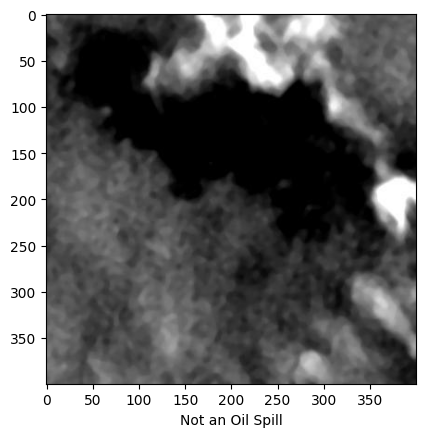

In [6]:
# Quick test
def plot_random_img(dataloader):
  label_map = {0: "Not an Oil Spill", 1: "Oil Spill"}
  images, labels = next(iter(train_dataloader))
  plt.imshow(images[0].squeeze(), cmap="gray")
  plt.xlabel(label_map.get(labels[0].item()))

plot_random_img(train_dataloader)

### Model, Loss Function, & Optimizer

nn.Sequential is used since it's straightfoward and not much complexity is required.

In [7]:
from torch import nn, optim

In [8]:
class SARImageClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        # First conv
        nn.Conv2d(1, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2), # 200x200
        # Second conv
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2), # 100x100
        # Third conv
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2), # 50x50
        nn.Flatten(),
        nn.Linear(50 * 50 * 64, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 1), # Final layer
        # No activation since its included in BCEWithLogitsLoss()
    )

  def forward(self, x):
    return self.model(x)

In [9]:
model = SARImageClassifier()

hw = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(hw)
model.to(device)
device

device(type='cuda')

In [10]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
EPOCHS = 20

In [12]:
for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0

  for images, labels in train_dataloader:
    # Converting labels to 2d tensor so it's in proper shape for loss functions
    images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item() # Fetching actual value from tensor

  avg_loss = running_loss / len(train_dataloader)
  print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}")

Epoch: 1, Loss: 0.6158
Epoch: 2, Loss: 0.5658
Epoch: 3, Loss: 0.5507
Epoch: 4, Loss: 0.5142
Epoch: 5, Loss: 0.4911
Epoch: 6, Loss: 0.4612
Epoch: 7, Loss: 0.4410
Epoch: 8, Loss: 0.4081
Epoch: 9, Loss: 0.3704
Epoch: 10, Loss: 0.3440
Epoch: 11, Loss: 0.3075
Epoch: 12, Loss: 0.2673
Epoch: 13, Loss: 0.2307
Epoch: 14, Loss: 0.2136
Epoch: 15, Loss: 0.2418
Epoch: 16, Loss: 0.2000
Epoch: 17, Loss: 0.1651
Epoch: 18, Loss: 0.1469
Epoch: 19, Loss: 0.1221
Epoch: 20, Loss: 0.1065


## Testing

In [18]:
class SARTestData(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.image_paths = []
    self.labels = []

    data_folder = os.path.join(root_dir, "data", "Samples")

    assert os.path.exists(data_folder) # Folder should exist

    # Scan folders and get image paths
    for img_file in os.listdir(data_folder):
      img_path = os.path.join(data_folder, img_file)
      self.image_paths.append(img_path)

      # Append corresponding label to self.labels
      if "_cls_0" in img_file:
        self.labels.append(0)
      elif "_cls_1" in img_file:
        self.labels.append(1)

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, index):
    img_path = self.image_paths[index]
    img = Image.open(img_path).convert("L") # Convert to grayscale if it isn't already
    label = self.labels[index]

    if self.transform:
      img = self.transform(img)

    return img, label

In [19]:
test_data = SARTestData("./CSIRO_Sentinel-1_SAR_Oil_Images/CSIRO_Sentinel-1_SAR_Oil_Images", transform=transform)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True, num_workers=4) # For low-end gpu, batch_size=8 & num_workers=2

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [20]:
def check_accuracy(dataloader, model, device):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for image, label in dataloader:
            image = image.to(device=device)
            label = label.to(device=device)

            scores = model(image)
            pred = (torch.sigmoid(scores) > 0.5).float()
            num_correct += (pred == label).sum()
            num_samples += pred.size(0)

        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

In [21]:
check_accuracy(test_dataloader, model=model, device=device)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Got 8 / 8 with accuracy 100.00
